In [86]:
# Importação de bibliotecas OpenCV, MatplotLib e Numpy
import cv2 # biblioteca de visao computacional OpenCV
import numpy as np # biblioteca de manipulacao de vetores e ferramentas matematicas e cientificas Numpy
import matplotlib as mpl # biblioteca de manipulacao e exibicao de dados Matplotlib
from matplotlib import pyplot as plt # Pyplot: modulo do Matplotlib para exibir as imagens 
import matplotlib.animation as animation
# utilizacao do matplotlib em formatacao para o Jupyter
%matplotlib inline 

In [87]:
# variáveis globais
minArea = 800 #definição da menor área de uma placa, baseado na menor placa de posível leitura
maxArea = 15000 #definição da maior área, baseado na maior placa encontrada (mais próxima da câmera)

def makeSafeCrop(img,rois, sf_zonex=0, sf_zoney=0,fatorx=2, fatory=2):
    crops = []
    for plate in rois:
        ny = plate[1] - sf_zoney
        nx = plate[0] - sf_zonex
        nh = plate[3] + fatory*sf_zoney
        nw = plate[2] + fatorx*sf_zonex
        if (nx <= 0): nx == 1
        if (ny <= 0): ny == 1
        if (nx+nw >= img.shape[1]): nw =  img.shape[1] - nx -1
        if (ny+nh >= img.shape[0]): nh =  img.shape[0] - ny -1
        if (nh == 0):
            nh = plate[3]
        if (nw == 0):
            nw = plate[2]
        crop = img[ny:ny+nh,nx:nx+nw]
        crops.append(crop)
    return crops

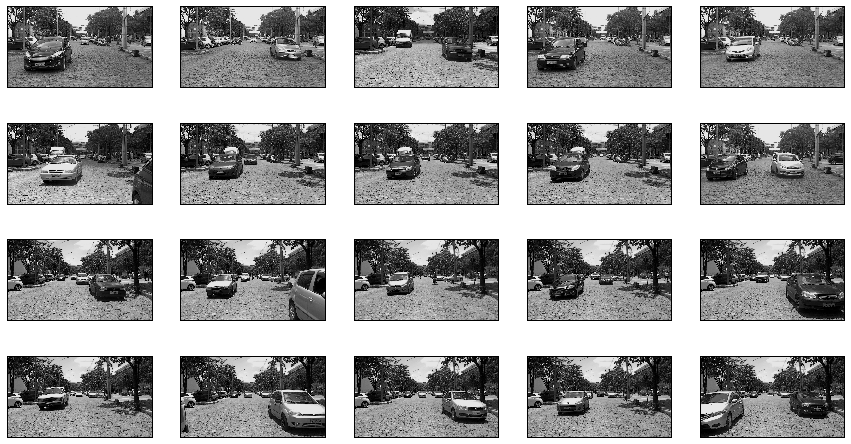

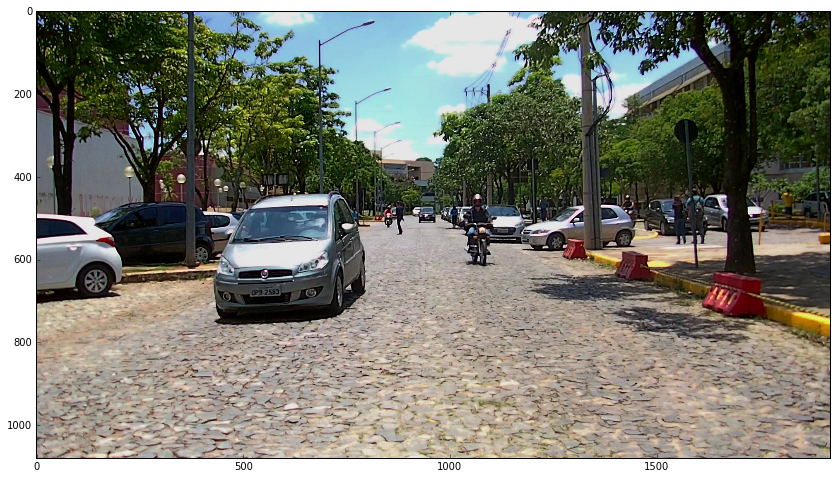

In [88]:
# Carregando as imagens e convertendo para escala de cinza
path = '../Data/' # caminho para a pasta das imagens
img_color = [] # lista de imagens coloridas
img = [] # lista de imagens em tons de cinza
plt.figure(figsize=(15,8)) # definição do tamanho da janela de exibição das imagens
# A cada iteração uma imagem é carregada e convertida para tons de cinza, ao passo que é armazenada nas listas acima 
for i in range(0,20): # A pasta data possui 20 imagens, i ira variar de 0 a 19
    # a funcao do OpenCV imread() realiza a leitura do arquivo de imagem
    # a funcao do OpenCV cvtColor() é usada para conversão de espaco de cores no caso RGB para GRAY
    img_color.append(cv2.imread(path + str(i+1) + '.png')) 
    img.append(cv2.cvtColor(img_color[i],cv2.COLOR_RGB2GRAY))  
    #Exibicao das imagens
    plt.subplot(4,5,i+1) #Cria subplots na imagem que possuira 4 linhas e 5 colunas com elementos de 1 a 20
    plt.imshow(img[i],cmap='gray') # Exibe a imagem com mapa de cores Gray
    plt.xticks([]), plt.yticks([]) # Remove a exibição dos valores das dimensões das imagens nos eixos x e y
# Visualização de uma única imagem em cor
plt.figure(figsize=(15,8)) 
plt.imshow(cv2.cvtColor(img_color[12], cv2.COLOR_BGR2RGB),cmap='gray')

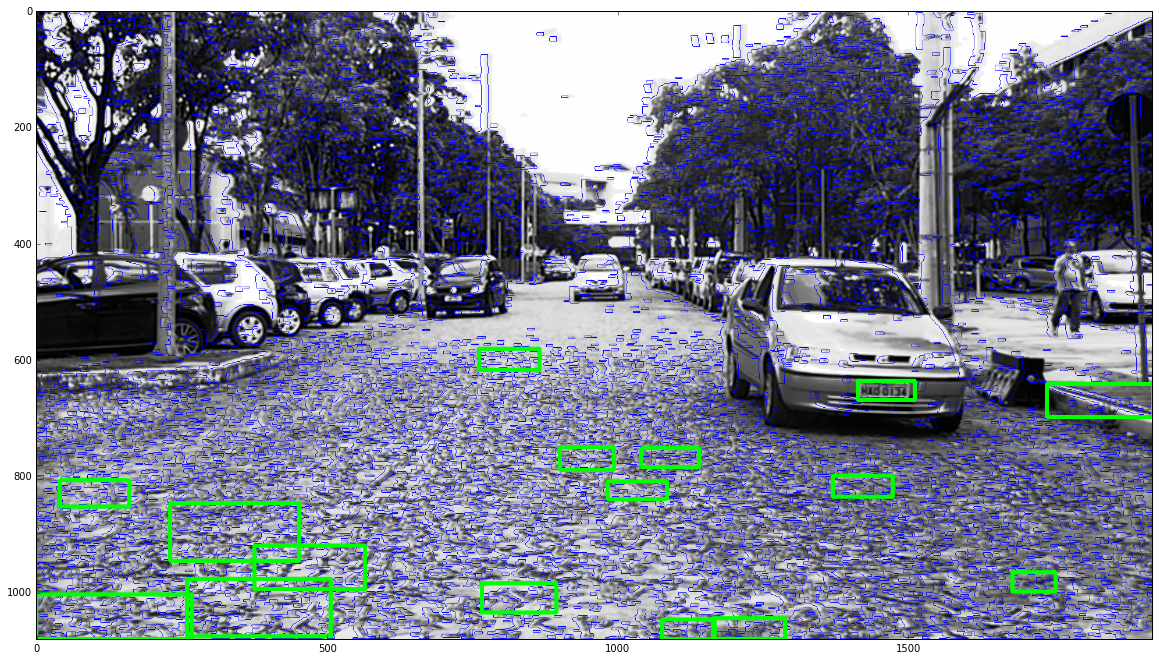

In [101]:
plt.figure(figsize=(20,30))
candidatos = []
indexim = 1
im = img[indexim]
im = cv2.blur(im,(5,5))
im = cv2.equalizeHist(im)
sobelx = cv2.Sobel(im,cv2.CV_64F,1,0,ksize=5) # filtro de sobel eixo x
sobelx = cv2.normalize(sobelx, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
_,xthr = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if(np.sum(xthr.ravel())/(xthr.shape[0]*xthr.shape[1]) > 127): xthr = 255 - xthr
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(12,2)) # MORPH_RECT devido ao formato da placa 
morphDx = cv2.dilate(xthr,kernel,1)
_,contours, hierarch = cv2.findContours(morphDx, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
color = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
cv2.drawContours(color, contours, -1, (0,0,255), 1)
rois1 = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if(area < maxArea and area > minArea):
        x,y,w,h = cv2.boundingRect(cnt)
        #cv2.rectangle(color,(x,y),(x+w,y+h),(255,0,0),3)
        ar = 1.0*h/w
        if(ar >= 0.25 and ar <= 0.45):
            cv2.rectangle(color,(x,y),(x+w,y+h),(0,255,0),5)
            rois1.append([x,y,w,h])

for crop in makeSafeCrop(img[indexim],rois1):
    candidatos.append(crop)    
plt.imshow(color,cmap='gray')

In [102]:
print len(candidatos)

16


16


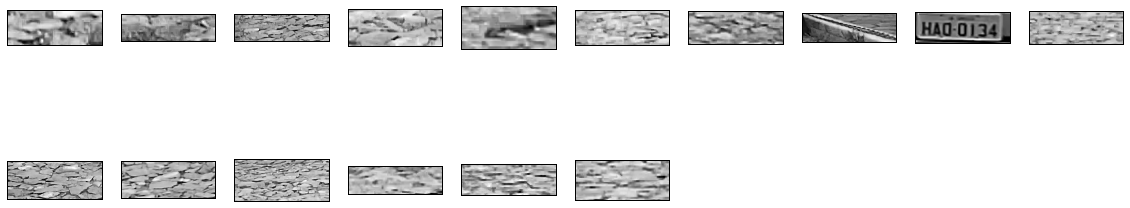

In [103]:
cnd_nb = len(candidatos)
print cnd_nb
plt.figure(figsize=(20,5))
for i in range(cnd_nb):
    plt.subplot(cnd_nb/10+1,10,i+1)
    plt.imshow(candidatos[i],cmap='gray'), plt.xticks([]), plt.yticks([])

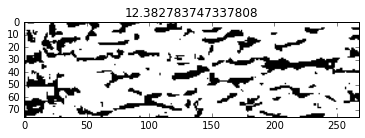

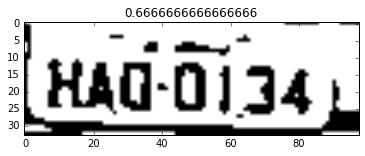

In [104]:
count_cand = 0
idx_selectedcand = []
center_std = []
for cand in candidatos:
    if(cand.shape[0]!=0 or cand.shape[1]!=0):
        gaussian = cv2.GaussianBlur(cand, (9,9), 10.0)
        unsharp_image = cv2.addWeighted(cand, 2, gaussian, -0.3, 0)
        ret,thr = cv2.threshold(unsharp_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ker = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
        mor = cv2.morphologyEx(thr,cv2.MORPH_CLOSE,ker)
        _,contours,hierarquia = cv2.findContours(mor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_cont = cv2.cvtColor(thr,cv2.COLOR_GRAY2BGR)
        foundflag = 0
        center = []
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            ar = 1.0*h/w
            if(h>=10 and w<=60 and ar > 0.7):
                foundflag = foundflag+1
                center.append(y+h/2)
                #cv2.rectangle(img_cont,(x,y),(x+w,y+h),(0,255,0),1)   
        if foundflag >=5 :
            if(np.std(center) < 4):
                idx_selectedcand.append(count_cand)
                center_std.append(np.std(center))
            plt.figure()
            plt.title(str(np.std(center)))
            plt.imshow(img_cont,'gray')
    count_cand = count_cand + 1

1


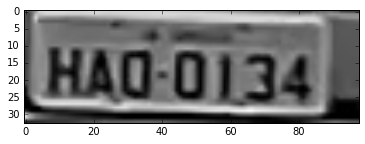

In [105]:
number = len(idx_selectedcand)
if number > 1 :
    placa = candidatos[idx_selectedcand[np.argmin(center_std)]]
    arg = idx_selectedcand[np.argmin(center_std)]
else:
    placa = candidatos[idx_selectedcand[0]]
    arg = idx_selectedcand[0]
print number

plt.imshow(placa,'gray')

(<matplotlib.image.AxesImage at 0x7f547c8075d0>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

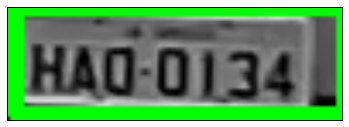

In [106]:
selected = [0,0,placa.shape[1],placa.shape[0]]
_,thr = cv2.threshold(placa,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_,contours,_ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_cont = cv2.cvtColor(placa,cv2.COLOR_GRAY2BGR)
#cv2.drawContours(img_cont, contours, -1, (0,255,0), 3)
count_cnt = 0
for cnt in contours:
    epsilon = 0.02*cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if(len(approx) >= 3):
        x,y,w,h = cv2.boundingRect(cnt)
        if(w*h >= placa.shape[0]*placa.shape[1]/3):
            selected = [x,y,w,h]
            count_cnt+=1
            cv2.rectangle(img_cont,(x,y),(x+w,y+h),(0,255,0),3)
plt.imshow(img_cont,cmap='gray'),plt.xticks([]), plt.yticks([])

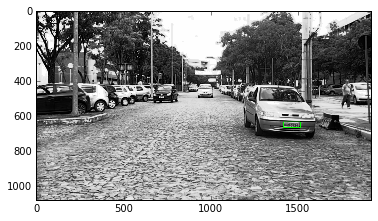

In [107]:
local = []
local.append([rois1[arg][0]+selected[0],rois1[arg][1]+selected[1],selected[2],selected[3]])
color = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
cv2.rectangle(color,(local[0][0],local[0][1]),(local[0][0]+local[0][2],local[0][1]+local[0][3]),(0,255,0),3)
plt.imshow(color,'gray')

0
